In [1]:
import os
from pathlib import Path
from IPython.display import Image, SVG, display

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

import torch.nn.functional as F
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable

In [2]:
# @markdown `download_mnist()`: Function to download MNIST.

def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

In [3]:
#@markdown To get started exploring the dataset, here are a few plotting functions:

#@markdown `get_plotting_color()`: Returns a color for the specific dataset, e.g. "train" or model index.
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 857kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 660kB/s]

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


<Axes: title={'center': 'Examples per class'}, xlabel='Class'>

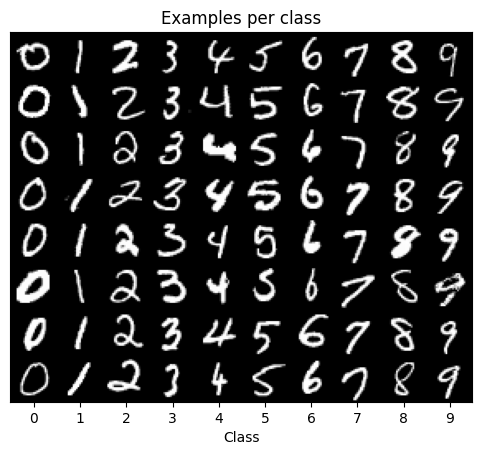

In [4]:
train_set, valid_set, test_set = download_mnist()
plot_examples(train_set)

In [5]:
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classes

class MultiLayerPerceptron(torch.nn.Module):
  """
  Simple multilayer perceptron model class with one hidden layer.
  """

  def __init__(
      self,
      num_inputs=NUM_INPUTS,
      num_hidden=100,
      num_outputs=NUM_OUTPUTS,
      activation_type="sigmoid",
      bias=False,
      ):
    """
    Initializes a multilayer perceptron with a single hidden layer.

    Arguments:
    - num_inputs (int, optional): number of input units (i.e., image size)
    - num_hidden (int, optional): number of hidden units in the hidden layer
    - num_outputs (int, optional): number of output units (i.e., number of
      classes)
    - activation_type (str, optional): type of activation to use for the hidden
      layer ('sigmoid', 'tanh', 'relu' or 'linear')
    - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights
    """


    super().__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.activation_type = activation_type
    self.bias = bias

    # default weights (and biases, if applicable) initialization is used
    # see https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py
    self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
    self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

    self._store_initial_weights_biases()

    self._set_activation() # activation on the hidden layer
    self.softmax = torch.nn.Softmax(dim=1) # activation on the output layer


  def _store_initial_weights_biases(self):
    """
    Stores a copy of the network's initial weights and biases.
    """

    self.init_lin1_weight = self.lin1.weight.data.clone()
    self.init_lin2_weight = self.lin2.weight.data.clone()
    if self.bias:
      self.init_lin1_bias = self.lin1.bias.data.clone()
      self.init_lin2_bias = self.lin2.bias.data.clone()

  def _set_activation(self):
    """
    Sets the activation function used for the hidden layer.
    """

    if self.activation_type.lower() == "sigmoid":
      self.activation = torch.nn.Sigmoid() # maps to [0, 1]
    elif self.activation_type.lower() == "tanh":
      self.activation = torch.nn.Tanh() # maps to [-1, 1]
    elif self.activation_type.lower() == "relu":
      self.activation = torch.nn.ReLU() # maps to positive
    elif self.activation_type.lower() == "identity":
      self.activation = torch.nn.Identity() # maps to same
    else:
      raise NotImplementedError(
          f"{self.activation_type} activation type not recognized. Only "
          "'sigmoid', 'relu' and 'identity' have been implemented so far."
          )

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets. This variable is not used
      here. However, it may be needed for other learning rules, to it is
      included as an argument here for compatibility.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred

  def forward_backprop(self, X):
    """
    Identical to forward(). Should not be overwritten when creating new
    child classes to implement other learning rules, as this method is used
    to compare the gradients calculated with other learning rules to those
    calculated with backprop.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred


  def list_parameters(self):
    """
    Returns a list of model names for a gradient dictionary.

    Returns:
    - params_list (list): List of parameter names.
    """

    params_list = list()

    for layer_str in ["lin1", "lin2"]:
      params_list.append(f"{layer_str}_weight")
      if self.bias:
        params_list.append(f"{layer_str}_bias")

    return params_list


  def gather_gradient_dict(self):
    """
    Gathers a gradient dictionary for the model's parameters. Raises a
    runtime error if any parameters have no gradients.

    Returns:
    - gradient_dict (dict): A dictionary of gradients for each parameter.
    """

    params_list = self.list_parameters()

    gradient_dict = dict()
    for param_name in params_list:
      layer_str, param_str = param_name.split("_")
      layer = getattr(self, layer_str)
      grad = getattr(layer, param_str).grad
      if grad is None:
        raise RuntimeError("No gradient was computed")
      gradient_dict[param_name] = grad.detach().clone().numpy()

    return gradient_dict

In [6]:
class BasicOptimizer(torch.optim.Optimizer):
  """
  Simple optimizer class based on the SGD optimizer.
  """
  def __init__(self, params, lr=0.01, weight_decay=0):
    """
    Initializes a basic optimizer object.

    Arguments:
    - params (generator): Generator for torch model parameters.
    - lr (float, optional): Learning rate.
    - weight_decay (float, optional): Weight decay.
    """

    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr}")
    if weight_decay < 0.0:
        raise ValueError(f"Invalid weight_decay value: {weight_decay}")

    defaults = dict(
        lr=lr,
        weight_decay=weight_decay,
        )

    super().__init__(params, defaults)

  def step(self):
      """
      Performs a single optimization step.
      """

      for group in self.param_groups:
        for p in group["params"]:

          # only update parameters with gradients
          if p.grad is not None:

            # apply weight decay to gradient, if applicable
            if group["weight_decay"] != 0:
              p.grad = p.grad.add(p, alpha=group["weight_decay"])

            # apply gradient-based update
            p.data.add_(p.grad, alpha=-group["lr"])

In [ ]:
# 07/19 Train function was modified to allow for multiple types of loss as FA prefers CrossEntropy

#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model_mirror(MLP, train_loader, valid_loader, optimizer, num_epochs=5, loss_type="NLL", mirror=False, m_lr=0.01, noise_amplitude=1):
  """
  Train a model for several epochs.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  results_dict = {
      "avg_train_losses": list(),
      "avg_valid_losses": list(),
      "avg_train_accuracies": list(),
      "avg_valid_accuracies": list(),
  }

  for e in tqdm(range(num_epochs)):
    no_train = True if e == 0 else False # to get a baseline
    latest_epoch_results_dict = train_epoch_mirror(
        MLP, train_loader, valid_loader, optimizer=optimizer, loss_type=loss_type, no_train=no_train, mirror=mirror, m_lr=m_lr, noise_amplitude=noise_amplitude
        )

    for key, result in latest_epoch_results_dict.items():
      if key in results_dict.keys() and isinstance(results_dict[key], list):
        results_dict[key].append(latest_epoch_results_dict[key])
      else:
        results_dict[key] = result # copy latest

  return results_dict


def train_epoch_mirror(MLP, train_loader, valid_loader, optimizer, loss_type, no_train=False, mirror=False, m_lr=0.01, noise_amplitude=1):
  """
  Train a model for one epoch.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - no_train (bool, optional): If True, the model is not trained for the
    current epoch. Allows a baseline (chance) performance to be computed in the
    first epoch before training starts.

  Returns:
  - epoch_results_dict (dict): Dictionary storing epoch results on training
    and validation data.
  """

  if loss_type == "NLL":
    criterion = torch.nn.NLLLoss()
    do_log = True
  #Better loss type for FA
  elif loss_type == "CrossEntropy":
    criterion = torch.nn.CrossEntropyLoss()
    do_log = False
  else:
    raise NotImplementedError(
          f"{loss_type} loss type not recognized."
          )

  epoch_results_dict = dict()
  for dataset in ["train", "valid"]:
    for sub_str in ["correct_by_class", "seen_by_class"]:
      epoch_results_dict[f"{dataset}_{sub_str}"] = {
          i:0 for i in range(MLP.num_outputs)
          }

  MLP.train()
  train_losses, train_acc = list(), list()
  for X, y in train_loader:
    y_pred = MLP(X, y=y)
    #loss = criterion(torch.log(y_pred), y)
    if do_log:
      loss = criterion(torch.log(y_pred), y)
    else:
      loss = criterion(y_pred, y)
    
    acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
    train_losses.append(loss.item() * len(y))
    train_acc.append(acc.item() * len(y))
    update_results_by_class_in_place(
        y, y_pred.detach(), epoch_results_dict, dataset="train",
        num_classes=MLP.num_outputs
        )
    optimizer.zero_grad()
    if not no_train:
      loss.backward(retain_graph=True)
      optimizer.step()

    if mirror:
      MLP.mirror(X, m_lr, noise_amplitude)

  num_items = len(train_loader.dataset)
  epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
  epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

  MLP.eval()
  valid_losses, valid_acc = list(), list()
  with torch.no_grad():
    for X, y in valid_loader:
      y_pred = MLP(X)
      if do_log:
        loss = criterion(torch.log(y_pred), y)
      else:
        loss = criterion(y_pred, y)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      valid_losses.append(loss.item() * len(y))
      valid_acc.append(acc.item() * len(y))
      update_results_by_class_in_place(
          y, y_pred.detach(), epoch_results_dict, dataset="valid"
          )

  num_items = len(valid_loader.dataset)
  epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
  epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

  return epoch_results_dict


def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
  """
  Updates results dictionary in place during a training epoch by adding data
  needed to compute the accuracies for each class.

  Arguments:
  - y (torch Tensor): target labels
  - y_pred (torch Tensor): predicted targets
  - result_dict (dict): Dictionary storing epoch results on training
    and validation data.
  - dataset (str, optional): Dataset for which results are being added.
  - num_classes (int, optional): Number of classes.
  """

  correct_by_class = None
  seen_by_class = None

  y_pred = np.argmax(y_pred, axis=1)
  if len(y) != len(y_pred):
    raise RuntimeError("Number of predictions does not match number of targets.")

  for i in result_dict[f"{dataset}_seen_by_class"].keys():
    idxs = np.where(y == int(i))[0]
    result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

    num_correct = int(sum(y[idxs] == y_pred[idxs]))
    result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

In [55]:
#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

#taken from Ammar's code
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            y_pred = model(X)
            predicted = torch.argmax(y_pred, axis=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    accuracy = 100 * correct / total
    return accuracy

In [290]:
# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

MLP = MultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [291]:
LR = 0.01
backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

In [292]:
NUM_EPOCHS = 10

MLP_results_dict = train_model_mirror(
    MLP,
    train_loader,
    valid_loader,
    optimizer=backprop_optimizer,
    num_epochs=NUM_EPOCHS,
    loss_type="NLL"
    )

100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


<Axes: title={'center': 'Performance across learning'}, xlabel='Epoch', ylabel='Loss'>

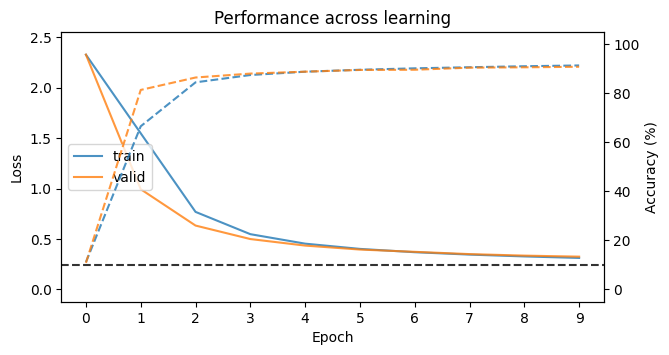

In [293]:
plot_results(MLP_results_dict)

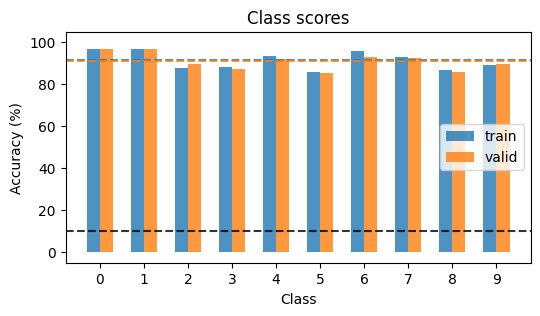

In [294]:
plot_scores_per_class(MLP_results_dict);

In [63]:
class LinearFAFunction(torch.autograd.Function):

    @staticmethod
    # same as reference linear function, but with additional fa tensor for backward
    def forward(context, input, weight, weight_fa, bias=None):
        context.save_for_backward(input, weight, weight_fa, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(context, grad_output):
        input, weight, weight_fa, bias = context.saved_tensors
        grad_input = grad_weight = grad_weight_fa = grad_bias = None

        if context.needs_input_grad[0]:
            # all of the logic of FA resides in this one line
            # calculate the gradient of input with fixed fa tensor, rather than the "correct" model weight
            grad_input = grad_output.mm(weight_fa.to(grad_output.device))
        if context.needs_input_grad[1]:
            # grad for weight with FA'ed grad_output from downstream layer
            # it is same with original linear function
            grad_weight = grad_output.t().mm(input)
        if bias is not None and context.needs_input_grad[3]:
            grad_bias = grad_output.sum(0).squeeze(0)

        #return grad_input, grad_weight, grad_bias, grad_nonlinearity, grad_target
        return grad_input, grad_weight, grad_bias, grad_weight_fa, None


In [64]:
class FAPerceptron(MultiLayerPerceptron):

  def __init__(self, clamp_output=True, **kwargs):

    super().__init__(**kwargs)
    #Create feedback weights
    self.lin1.weight_fa = Variable(torch.FloatTensor(self.num_hidden, self.num_inputs), requires_grad=False)
    self.lin2.weight_fa = Variable(torch.FloatTensor(self.num_outputs, self.num_hidden), requires_grad=False)
    #Initiate them randomly. In standard FA these are constant and never changed
    torch.nn.init.kaiming_uniform_(self.lin1.weight_fa)
    torch.nn.init.kaiming_uniform_(self.lin2.weight_fa)


  def forward(self, X, y=None):

    h = LinearFAFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.weight_fa,
        self.lin1.bias
    )

    y_pred = LinearFAFunction.apply(
        h,
        self.lin2.weight,
        self.lin2.weight_fa,
        self.lin2.bias
    )

    return y_pred

In [295]:
# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

FA_MLP = FAPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloadersa
BATCH_SIZE = 32

optimizer_fa = torch.optim.SGD(FA_MLP.parameters(),
                            lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)

#LR = 0.01
#backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

NUM_EPOCHS = 10

FA_results_dict = train_model_mirror(
    FA_MLP,
    train_loader,
    valid_loader,
    optimizer=optimizer_fa,
    num_epochs=NUM_EPOCHS,
    loss_type="CrossEntropy"
    )


100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


<Axes: title={'center': 'Performance across learning'}, xlabel='Epoch', ylabel='Loss'>

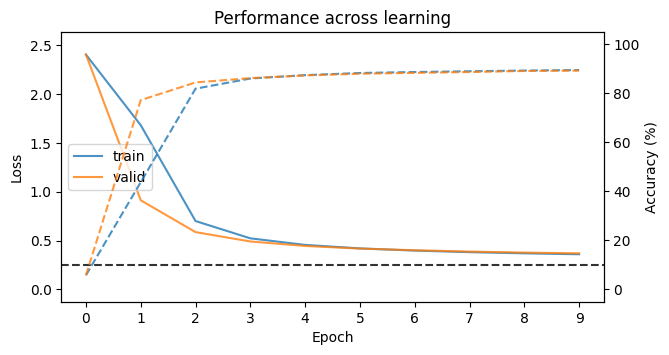

In [296]:
#modified the loss function so not quite the same
plot_results(FA_results_dict)

<Axes: title={'center': 'Class scores'}, xlabel='Class', ylabel='Accuracy (%)'>

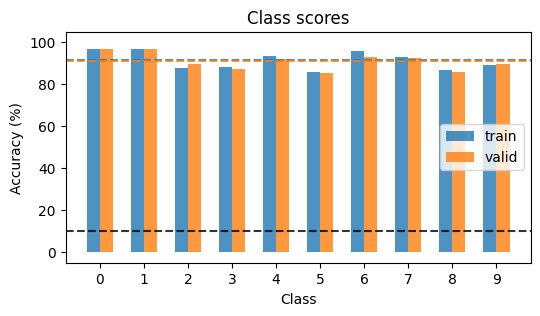

In [297]:
plot_scores_per_class(MLP_results_dict)

In [91]:
test_accuracy_BP = evaluate_accuracy(MLP, test_loader)
print(f"Test Accuracy BP: {test_accuracy_BP:.2f}%")
test_accuracy_FA = evaluate_accuracy(FA_MLP, test_loader)
print(f"Test Accuracy FA: {test_accuracy_FA:.2f}%")

Test Accuracy BP: 89.46%
Test Accuracy FA: 88.50%


In [278]:
class LinearWMFunction(torch.autograd.Function):

    @staticmethod
    # same as reference linear function, but with additional fa tensor for backward
    def forward(context, input, weight, weight_fa, bias=None):

        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)

        #output saved for Hebbian
        context.save_for_backward(input, weight, weight_fa, bias)

        return output

    @staticmethod
    def backward(context, grad_output):
        #the `weight` variable should always go unused as there is no backpropagation
        input, weight, weight_fa, bias= context.saved_tensors
        grad_input = grad_weight = grad_weight_fa = grad_bias = None

        if context.needs_input_grad[0]:
            # all of the logic of FA resides in this one line
            # calculate the gradient of input with fixed fa tensor, rather than the "correct" model weight
            grad_input = grad_output.mm(weight_fa.to(grad_output.device))
        if context.needs_input_grad[1]:
            # grad for weight with FA'ed grad_output from downstream layer
            # it is same with original linear function
            grad_weight = grad_output.t().mm(input)
        if bias is not None and context.needs_input_grad[3]:
            grad_bias = grad_output.sum(0).squeeze(0)

        #must return a grad for each input into `forward`. This means there are useless empty ones, like grad_weight_fa
        return grad_input, grad_weight, grad_weight_fa, grad_bias
    
class WMPerceptron(MultiLayerPerceptron):

  def __init__(self, **kwargs):

    super().__init__(**kwargs)
    #Create feedback weights
    self.lin1.weight_fa = Variable(torch.FloatTensor(self.num_hidden, self.num_inputs), requires_grad=False)
    self.lin2.weight_fa = Variable(torch.FloatTensor(self.num_outputs, self.num_hidden), requires_grad=False)
    #Initiate them randomly. In standard FA these are constant and never changed
    torch.nn.init.kaiming_uniform_(self.lin1.weight_fa)
    torch.nn.init.kaiming_uniform_(self.lin2.weight_fa)


  def forward(self, X, y=None):

    h = LinearWMFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.weight_fa,
        self.lin1.bias
    )

    y_pred = LinearWMFunction.apply(
        h,
        self.lin2.weight,
        self.lin2.weight_fa,
        self.lin2.bias
    )

    return y_pred
  
  #Mirror function, converted from https://github.com/makrout/Deep-Learning-without-Weight-Transport/blob/master/fcnn/FCNN_WM.py
  def mirror(self, X, m_lr, noise_amplitude):

    with torch.no_grad():

        #randomly stimulate each layer
        noise_in = noise_amplitude * (torch.randn_like(X.reshape(-1, self.num_inputs)) - 0.5)
        #output of random stim
        noise_out = noise_in.mm(self.lin1.weight.t())

        #update FA weights via hebbian
        grad_fa = m_lr * noise_out.t().mm(noise_in)

        #grad_fa = grad_fa / len(noise_in) # average across batch
        # # center around 0
        #grad_fa = grad_fa - grad_fa.mean(axis=0)
        self.lin1.weight_fa += grad_fa

        x = torch.randn(self.lin1.weight_fa.shape[0], 32, requires_grad=False)
        y = x.t().mm(self.lin1.weight_fa)
        y_std = torch.mean(torch.std(y, dim=1))
        self.lin1.weight_fa = 0.5 * self.lin1.weight_fa / y_std

        # if self.bias is not None:
        #     noise_out += self.bias.unsqueeze(0).expand_as(noise_out)

        noise_in = noise_amplitude * (torch.randn_like(noise_out) - 0.5)
        noise_out = noise_in.mm(self.lin2.weight.t())
        grad_fa = m_lr * noise_out.t().mm(noise_in)
        # average across batch
        #grad_fa = grad_fa / len(noise_in) 
        # center around 0
        #grad_fa = grad_fa - grad_fa.mean(axis=0)
        self.lin2.weight_fa += grad_fa
        # if self.bias is not None:
        #     noise_out += self.bias.unsqueeze(0).expand_as(noise_out)

        x = torch.randn(self.lin2.weight_fa.shape[0], 32, requires_grad=False)
        y = x.t().mm(self.lin2.weight_fa)
        y_std = torch.mean(torch.std(y, dim=1))
        self.lin2.weight_fa = 0.5 * self.lin2.weight_fa / y_std



    return


In [298]:
# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

WM_MLP = WMPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloadersa
BATCH_SIZE = 32

optimizer_fa = torch.optim.SGD(WM_MLP.parameters(),
                            lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)

#LR = 0.01
#backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

NUM_EPOCHS = 10

WM_results_dict = train_model_mirror(
    WM_MLP,
    train_loader,
    valid_loader,
    optimizer=optimizer_fa,
    num_epochs=NUM_EPOCHS,
    loss_type="CrossEntropy",
    mirror=True,
    m_lr=0.001,
    noise_amplitude=1
    )


100%|██████████| 10/10 [02:01<00:00, 12.19s/it]


<Axes: title={'center': 'Performance across learning'}, xlabel='Epoch', ylabel='Loss'>

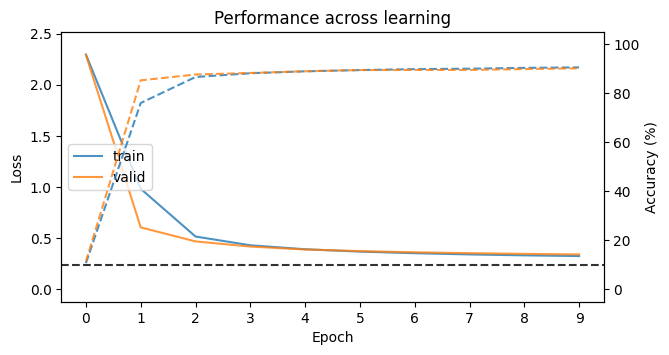

In [299]:
plot_results(WM_results_dict)

<Axes: title={'center': 'Class scores'}, xlabel='Class', ylabel='Accuracy (%)'>

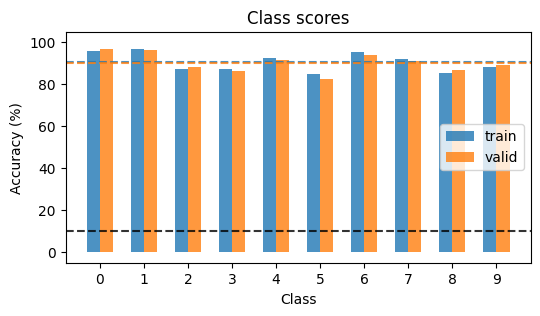

In [300]:
plot_scores_per_class(WM_results_dict)

In [301]:
test_accuracy_WM = evaluate_accuracy(WM_MLP, test_loader)
print(f"Test Accuracy WM: {test_accuracy_WM:.2f}%")

Test Accuracy WM: 90.94%


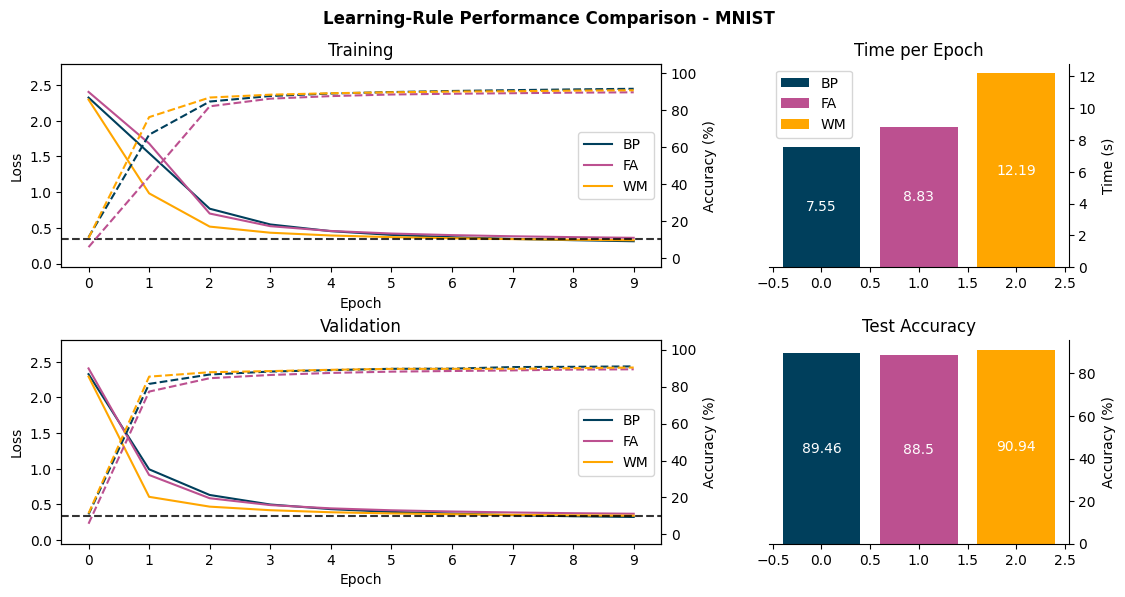

In [ ]:
epochs = 10
num_classes = 10

chance = 100 / num_classes

def create_grid(fig, spec):
    axes = []
    for row in range(spec.nrows):
        for col in range(spec.ncols):
            axes.append(fig.add_subplot(spec[row,col]))
    return axes

fig = plt.figure(figsize=(13,6))
fig.suptitle("Learning-Rule Performance Comparison - MNIST", weight='bold', y=0.94)

widths = [1,0.5]

spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths)

train_ax = fig.add_subplot(spec[0,0])
valid_ax = fig.add_subplot(spec[1,0])
time_ax = fig.add_subplot(spec[0,1])
acc_ax = fig.add_subplot(spec[1,1])

fig.subplots_adjust(wspace=0.24, hspace=0.36, top=0.85, bottom=0.05)

train_ax.set_xticks(np.arange(epochs))
train_ax.set_xlabel("Epoch")
train_ax.set_ylabel("Loss")
train_ax.set_ylim(-0.05,2.8)
train_ax.set_title("Training")


acc_train = train_ax.twinx()
acc_train.spines[["right"]].set_visible(True)
acc_train.axhline(chance, ls="dashed", color="k", alpha=0.8)
acc_train.set_ylim(-5, 105)
acc_train.set_ylabel("Accuracy (%)")

valid_ax.set_xticks(np.arange(epochs))
valid_ax.set_xlabel("Epoch")
valid_ax.set_ylabel("Loss")
valid_ax.set_ylim(-0.05,2.8)
valid_ax.set_title("Validation")

acc_valid = valid_ax.twinx()
acc_valid.spines[["right"]].set_visible(True)
acc_valid.axhline(chance, ls="dashed", color="k", alpha=0.8)
acc_valid.set_ylim(-5, 105)
acc_valid.set_ylabel("Accuracy (%)")

dicts = [MLP_results_dict,FA_results_dict,WM_results_dict]
labels = ['BP','FA','WM']
colors = ["#003f5c", "#bc5090", "#ffa600"]
times = [7.55,8.83,12.19]
accuracies = [test_accuracy_BP, test_accuracy_FA, test_accuracy_WM]

bars = []

for data_dict, label, color, time in zip(dicts,labels,colors, times):
    train_ax.plot(data_dict['avg_train_losses'], label=label, color=color)
    acc_train.plot(data_dict['avg_train_accuracies'], label=label, color=color, ls="dashed")

    valid_ax.plot(data_dict['avg_valid_losses'], label=label, color=color)
    acc_valid.plot(data_dict['avg_valid_accuracies'], label=label, color=color, ls="dashed")

acc = acc_ax.bar(np.arange(len(times)), height=accuracies, color=colors, label=labels)
acc_ax.yaxis.set_label_position("right")
acc_ax.yaxis.tick_right()
acc_ax.set_ylabel("Accuracy (%)")
acc_ax.spines[['top', 'left']].set_visible(False)
acc_ax.set_title("Test Accuracy")
acc_ax.bar_label(acc, label_type='center', c='white')

time = time_ax.bar(np.arange(len(times)), height=times, color=colors, label=labels)
time_ax.yaxis.set_label_position("right")
time_ax.yaxis.tick_right()
time_ax.set_ylabel("Time (s)")
time_ax.spines[['top', 'left']].set_visible(False)
time_ax.set_title("Time per Epoch")
time_ax.bar_label(time, label_type='center', c='white')

train_ax.legend(loc="center right")
valid_ax.legend(loc="center right")
time_ax.legend(loc='upper left')

In [283]:
WM_MLP.lin1.weight

Parameter containing:
tensor([[ 3.8333e-02,  1.9148e-02, -1.7998e-02,  ...,  2.3108e-02,
          3.8837e-02,  2.1776e-02],
        [ 9.3922e-03,  2.4703e-02,  3.5843e-02,  ...,  9.7482e-03,
         -2.8355e-02,  2.2570e-02],
        [-2.0953e-02,  4.0720e-02, -6.3372e-03,  ..., -1.0501e-02,
         -2.8821e-02,  9.0095e-03],
        ...,
        [-8.9321e-03,  2.0487e-02,  3.3361e-02,  ...,  1.6002e-02,
          1.1665e-03, -1.1179e-02],
        [-1.5698e-03,  4.0708e-03,  6.4834e-05,  ..., -2.6405e-02,
         -2.8732e-02,  8.9488e-03],
        [-2.8535e-02, -6.5136e-03,  7.8456e-03,  ..., -2.7572e-02,
          3.3552e-02,  3.4154e-02]], requires_grad=True)

In [284]:
WM_MLP.lin1.weight_fa

tensor([[-2.5686e-01, -3.4374e-01, -4.0017e-01,  ..., -3.1637e-01,
         -3.0720e-01, -3.8600e-01],
        [ 7.3509e-01,  7.6200e-01,  7.6883e-01,  ...,  7.5677e-01,
          6.7612e-01,  8.0100e-01],
        [ 6.9505e-01,  8.3894e-01,  7.3324e-01,  ...,  7.3882e-01,
          6.8939e-01,  7.6636e-01],
        ...,
        [ 4.3115e-01,  4.7314e-01,  4.9049e-01,  ...,  4.6014e-01,
          4.2247e-01,  4.1531e-01],
        [ 5.5064e-01,  5.7543e-01,  5.4650e-01,  ...,  5.1870e-01,
          4.8589e-01,  5.5400e-01],
        [-8.2711e-02, -8.7224e-05,  8.8203e-03,  ..., -3.6081e-02,
          4.5550e-02,  4.3205e-02]])